<a href="https://colab.research.google.com/github/RozhanMk/Time-Series-Analysis/blob/master/ANN_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

In [ ]:
!curl -L -o air-passengers.zip\
  https://www.kaggle.com/api/v1/datasets/download/rakannimer/air-passengers

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   764  100   764    0     0   1457      0 --:--:-- --:--:-- --:--:--  6420


In [ ]:
!unzip air-passengers.zip

Archive:  air-passengers.zip
  inflating: AirPassengers.csv       


In [ ]:
df = pd.read_csv('AirPassengers.csv', index_col='Month', parse_dates=True)
df = df.dropna()
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


# One step model

In [ ]:
N_test = 12
train_df = df[:-N_test]
test_df = df[-N_test:]

train_idx = df.index <= train_df.index[-1]
test_idx = df.index > train_df.index[-1]

In [ ]:
series = df['#Passengers'].dropna().to_numpy()

N_lags = 10
data = []
target = []
for x in range(len(series) - N_lags):
  data.append(series[x:x+N_lags])
  target.append(series[x+N_lags])

data = np.array(data).reshape(-1, N_lags)
target = np.array(target)

X_train, y_train = data[:-N_test], target[:-N_test]
X_test, y_test = data[-N_test:], target[-N_test:]

In [ ]:
# Basic ANN
input_layer = Input(shape=(N_lags,))
h1 = Dense(32, activation="relu")(input_layer)
h2 = Dense(16, activation="relu")(h1)
output_layer = Dense(1, activation=None)(h2)
model = Model(input_layer, output_layer)

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
r = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - loss: 3550.0166 - mae: 45.6330 - val_loss: 10304.3828 - val_mae: 87.0502
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 3274.2983 - mae: 45.6603 - val_loss: 9964.6279 - val_mae: 85.4659
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 3123.8188 - mae: 44.7729 - val_loss: 8264.3877 - val_mae: 78.9864
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 2737.0046 - mae: 42.8855 - val_loss: 8366.0615 - val_mae: 78.7059
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 2279.2688 - mae: 37.7513 - val_loss: 7404.8579 - val_mae: 74.0524
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 2166.1355 - mae: 38.7746 - val_loss: 7270.5308 - val_mae: 73.1290
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 2287.3452 - mae: 38.2594 - val_loss: 7237.8130 - val_mae: 72.9236
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 2424.7141 - mae: 40.0329 - val_loss: 6629.9351 - val_mae: 68.2589
Epoc

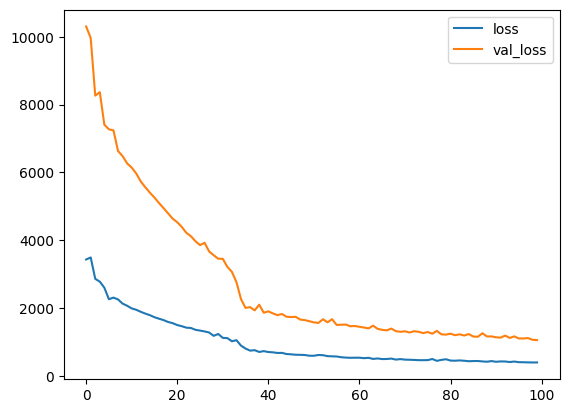

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
pred_tr = model.predict(X_train).flatten()
pred_te = model.predict(X_test).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [ ]:
train_idx[:N_lags] = False
df.loc[train_idx, "OneStep Train Prediction"] = pred_tr
df.loc[test_idx, "OneStep Test Prediction"] = pred_te

<Axes: xlabel='Month'>

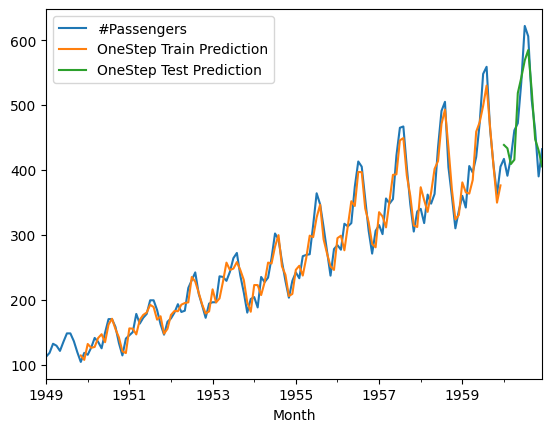

In [ ]:
df.plot()

In [ ]:
from sklearn.metrics import mean_squared_error

train_mse = np.sqrt(mean_squared_error(y_train, pred_tr))
test_mse = np.sqrt(mean_squared_error(y_test, pred_te))

print(f"Train RMSE: {train_mse}")
print(f"Test RMSE: {test_mse}")

Train RMSE: 19.708365678928708
Test RMSE: 32.422940494540285


# Multi step model

In [ ]:
last_xtr = X_train[-1].reshape(1, -1)
multi_step_pred = []
for _ in range(N_test):
  pred = model.predict(last_xtr)[0]
  last_xtr = np.roll(last_xtr, -1)
  last_xtr[-1][-1] = pred

  multi_step_pred.append(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

/tmp/ipython-input-14-477464069.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_xtr[-1][-1] = pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


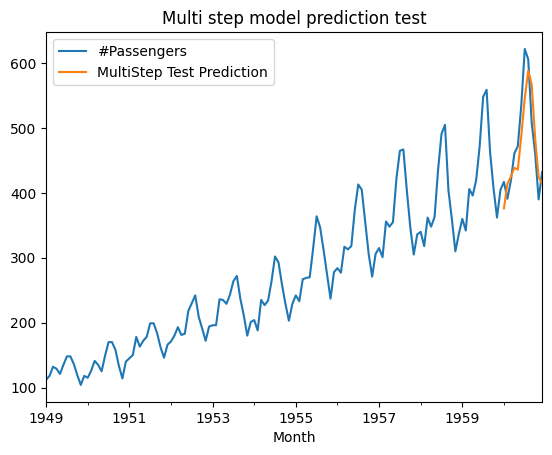

In [ ]:
df.loc[test_idx, "MultiStep Test Prediction"] = multi_step_pred
df[["#Passengers", "MultiStep Test Prediction"]].plot()
plt.title("Multi step model prediction test");

In [ ]:
test_mse = np.sqrt(mean_squared_error(multi_step_pred, df.loc[test_idx, "#Passengers"]))

print(f"Multi step test RMSE: {test_mse}")

Multi step test RMSE: 38.66319901737799


# Multi output model

In [ ]:
h = N_test
data = []
target = []
for i in range(len(series) - N_lags - h + 1):
  data.append(series[i : i+N_lags])
  target.append(series[i+N_lags : i+N_lags+h])

X = np.array(data)
y = np.array(target)
Xtr_m, ytr_m = X[:-1], y[:-1]
Xte_m, yte_m = X[[-1]], y[[-1]]

In [ ]:
Xtr_m.shape

(122, 10)

In [ ]:
ytr_m.shape

(122, 12)

In [ ]:
input_layer = Input(shape=(N_lags, ))
h1 = Dense(32, activation="relu")(input_layer)
h1 = Dense(32, activation="relu")(h1)
output_layer = Dense(ytr_m.shape[1])(h1)
model = Model(input_layer, output_layer)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,804 (7.05 KB)

 Trainable params: 1,804 (7.05 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam", loss="mse")
mtr_result = model.fit(Xtr_m, ytr_m,
                       epochs=200,
                       validation_data=(Xte_m, yte_m),
                       verbose=0)

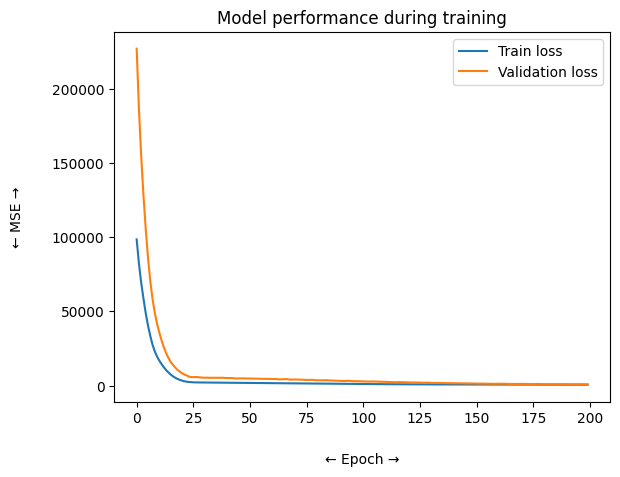

In [ ]:
plt.plot(mtr_result.history['loss'], label="Train loss")
plt.plot(mtr_result.history['val_loss'], label="Validation loss")
plt.xlabel("← Epoch →", labelpad=20)
plt.ylabel("← MSE →", labelpad=20)
plt.title("Model performance during training")
plt.legend();

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


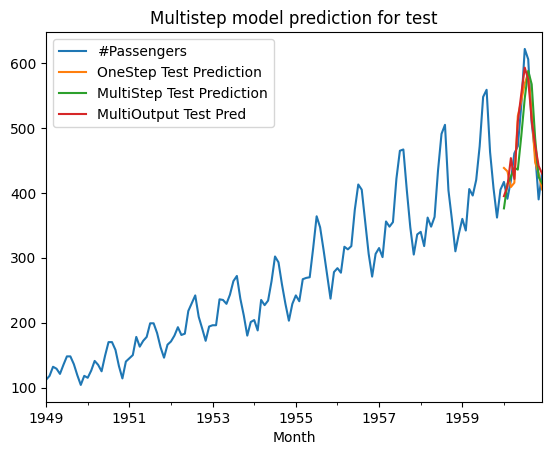

In [ ]:
mtr_test_pred = model.predict(Xte_m)
mtr_test_pred = mtr_test_pred.flatten()
df.loc[test_idx, "MultiOutput Test Pred"] = mtr_test_pred
df[["#Passengers",
            "OneStep Test Prediction",
            "MultiStep Test Prediction",
            "MultiOutput Test Pred"]].plot()
plt.title("Multistep model prediction for test");

In [ ]:
test_mse = np.sqrt(mean_squared_error(mtr_test_pred, df.loc[test_idx, "#Passengers"]))

print(f"Multi output test RMSE: {test_mse}")

Multi output test RMSE: 28.83870169289927
